# Data and Study Design

In our experiment we had two cohorts of mice. **Mice 2-5** received a fecal transplant from a **Healthy** human donor. **Mice 6-10** received am FMT from a human donor with **Ulcerative Colitis (UC)**. We refere to these mouse cohorts as the Healthy and UC cohorts.  

An overview of the experiment is provided in the following figure
![](figure/study_design.png)

In this notebook we will explore the two sources of data: qPCR for total bacterial load and reads from Amplicon sequencing. We will also go over the timing of fecal sample collection and perturbations as well as provide taxonomies for the associated amplicon sequences that were identified in the samples.

---

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import StandardScaler
lines_to_show=12


## Metadata

The following table is a metadata table.  For every sampleID it has the corresponding subject (mouse) and timepoint (in days) of fecal sample collection

In [6]:
metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata.head(lines_to_show)

,sampleID,subject,time
0,10-D0AM,10,0.0
1,10-D10,10,10.0
2,10-D11,10,11.0
3,10-D14,10,14.0
4,10-D16,10,16.0
5,10-D18,10,18.0
6,10-D1AM,10,1.0
7,10-D1PM,10,1.5
8,10-D21AM,10,21.0
9,10-D21PM,10,21.5


## qPCR


The following table is a qPCR table. This has the replicate measurements (3) of the qPCR for every sample (already normalized by the mass of the fecal pellet) in the units of CFU/g.

CFU/g: Colony Forming Units per gram of feces

In [7]:
qpcr = pd.read_csv('data/qpcr.tsv', sep='\t')
qpcr.head(lines_to_show)

,sampleID,measurement1,measurement2,measurement3
0,10-D0AM,3.124446e+07,6.624073e+07,2.146892e+07
1,10-D10,1.249714e+11,1.476571e+11,5.866129e+10
2,10-D11,1.430439e+11,2.154554e+11,2.931997e+11
3,10-D14,7.274684e+10,1.950943e+11,6.949483e+10
4,10-D16,9.364484e+10,1.167788e+11,1.107184e+11
5,10-D18,5.760466e+10,7.984920e+10,1.032151e+11
6,10-D1AM,8.787440e+09,1.503446e+10,1.081238e+10
7,10-D1PM,4.975814e+10,1.093237e+11,1.121214e+11
8,10-D21AM,1.305030e+11,2.303749e+11,1.680958e+11
9,10-D21PM,1.879675e+11,1.953849e+11,3.029993e+11


## Sequencing counts table - rows: ASVs, columns: samples

The following table is a read counts table. This shows the number of reads associated with each ASV for each sample ID.

In [8]:
counts = pd.read_csv('data/counts.tsv', sep='\t')
counts.head(lines_to_show)

,Unnamed: 0,10-D0AM,10-D10,10-D11,10-D14,10-D16,10-D18,10-D1AM,10-D1PM,10-D21AM,...,9-D60AM,9-D60PM,9-D61,9-D62,9-D63,9-D64AM,9-D64PM,9-D7,9-D8,9-D9
0,ASV_1,22,10503,21726,25990,21572,21352,17823,16916,26669,...,23613,20729,37601,38306,21944,12971,24560,12622,10323,10960
1,ASV_2,21,9319,17515,20188,14972,14868,6627,7697,20212,...,10875,11709,6582,7369,4935,7152,15477,7814,9361,8009
2,ASV_3,3,9380,17748,20899,15247,17260,45,1078,21997,...,21,6,120,21,502,1034,5944,19830,15778,22068
3,ASV_4,0,0,7,24,5,20,0,0,0,...,22,19,25,23,24,20,45,8,0,0
4,ASV_5,0,0,0,0,0,0,0,0,0,...,15,20,0,0,0,0,0,0,0,0
5,ASV_6,0,3066,3391,3617,3919,3874,0,26,4377,...,3496,3423,1102,5511,5398,3471,9295,1722,2431,2276
6,ASV_7,0,1612,2871,3172,2444,2769,922,1222,3760,...,1903,2187,1153,1280,846,1357,2866,1314,1482,1336
7,ASV_8,14,404,842,1022,469,346,380,453,273,...,56,55,16,17,9,27,89,272,532,548
8,ASV_9,0,2125,3261,3806,2642,2598,10071,6941,1678,...,1821,2001,639,479,654,1666,3398,2390,3350,2630
9,ASV_10,3,852,1401,1768,1589,1835,2723,1757,2737,...,224,676,291,143,79,187,469,1214,1928,1682


In [29]:
counts["10-D0AM"]

0       22
1       21
2        3
3        0
4        0
        ..
1468     0
1469     0
1470     0
1471     0
1472     0
Name: 10-D0AM, Length: 1473, dtype: int64

Recall that read counts are not quantitative (but are instead relative to the read depth). The total read depth for each sample can be computed as

In [57]:
read_depth=counts.sum()[1:] # first column was just the ASV number hence indexing from 1 to the end, removing the 0 index
read_depth.head(12)

10-D0AM         84
10-D10       46512
10-D11       82066
10-D14       96268
10-D16       78009
10-D18       82540
10-D1AM      49805
10-D1PM      48392
10-D21AM    108082
10-D21PM     70385
10-D22AM     59366
10-D22PM     73812
dtype: object

The read depth for each sample changes, but the read depth does not correspond to changes in total bacterial load. That is why we also have a qPCR measurement for estimating total bacterial load in each sample.

## ASV number, sequences and taxonomy

The taxonomy table relates the ASV number to the actual amplicon sequence associated with the ASV number. In addition you have the taxonomic information down to the species level (if the classification is known). When multiple species are provided it means that those species all have the same ASV (and this specific region of the 16S rRNA gene is not enough to destinguish them) and if `NaN` then that ASV did not have an associated species in the training set or more than 5 species were returned.

In [10]:
asv_and_taxonomy = pd.read_csv('data/asv_and_taxonomy.tsv', sep='\t')
asv_and_taxonomy.head(lines_to_show)

,name,sequence,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,ASV_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,ASV_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,ASV_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,ASV_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,cellulosilyticus/intestinalis/timonensis
4,ASV_5,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
5,ASV_6,TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
6,ASV_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/koreensis/kribbi/ovatus
7,ASV_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,ovatus
8,ASV_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,dorei/fragilis
9,ASV_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae


## Perturbation type with start and stop time (days) for each subject

Recall that there were three perturbations applied, High Fat Diet, Vancomycin, and Gentamicin. This table has the start and stop time (in days) for the perturbations

In [11]:
perturbations = pd.read_csv('data/perturbations.tsv', sep='\t')
perturbations.head(12)

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,High Fat Diet,21.5,28.5,6
5,High Fat Diet,21.5,28.5,7
6,High Fat Diet,21.5,28.5,8
7,High Fat Diet,21.5,28.5,9
8,High Fat Diet,21.5,28.5,10
9,Vancomycin,35.5,42.5,2


In [198]:
#Preprocess the data
subject_df_dict = dict()
for i in range(2,11):
    part_df = metadata[metadata["subject"]==i]
    maxlen = len(part_df)
    tmp_df = pd.DataFrame()
    for j in range(0,maxlen):
        smpid = part_df.iloc[j,0]
        smptime = part_df.iloc[j,2]
        ratio_row = counts[[smpid]].T/read_depth[smpid]
        ratio_row["total population"] = qpcr[qpcr["sampleID"]==smpid].mean(axis=1).iloc[0]
        ratio_row["time"] = smptime
        tmp_df = tmp_df.append(ratio_row)
    col_index = list(counts["Unnamed: 0"])
    col_index.append("total population")
    col_index.append("time")
    tmp_df.columns = col_index
    tmp_df = tmp_df.sort_values("time")
    subject_df_dict[i] = tmp_df

In [199]:
#This is what the dataframes look like, you can access the df for a particular subject using its int index
#The indices of the df will be the sample ID, the columns will be the ratio of the corresponding ASV
test_df = subject_df_dict[2]
display(test_df)
tmp_df = {"subject":[], ">0":[],">0.0001":[],">0.001":[],">0.01":[]}
for i in range(2,11):
    nonzero = len(subject_df_dict[i].mean()[subject_df_dict[i].mean()>0])
    more1 = len(subject_df_dict[i].max()[subject_df_dict[i].max()>0.0001])
    more2 = len(subject_df_dict[i].max()[subject_df_dict[i].max()>0.001])
    more3 = len(subject_df_dict[i].max()[subject_df_dict[i].max()>0.01])
    #print(f"There are {nonzero:d} ASVs that have presented in the subject {i:d}")
    #print(f"There are {more1:d} ASVs that have a maximum ratio more than 0.0001 in the subject {i:d}")
    #print(f"There are {more2:d} ASVs that have a maximum ratio more than 0.001 in the subject {i:d}")
    #print(f"There are {more3:d} ASVs that have a maximum ratio more than 0.01 in the subject {i:d}")
    tmp_df["subject"].append(i)
    tmp_df[">0"].append(nonzero)
    tmp_df[">0.0001"].append(more1)
    tmp_df[">0.001"].append(more2)
    tmp_df[">0.01"].append(more3)
#Some stats for you
stat_df = pd.DataFrame(tmp_df)
display(stat_df)

,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_1466,ASV_1467,ASV_1468,ASV_1469,ASV_1470,ASV_1471,ASV_1472,ASV_1473,total population,time
2-D0AM,0.279857,0.045837,0.002546,0.000764,0.001528,0.000000,0.017061,0.011204,0.045327,0.052457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.724134e+06,0.0
2-D0PM,0.299664,0.075030,0.000636,0.000000,0.001181,0.000000,0.015714,0.004451,0.065946,0.014079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.674454e+07,0.5
2-D1AM,0.055078,0.042304,0.000316,0.000285,0.006134,0.000063,0.025737,0.022480,0.000000,0.126154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.554379e+11,1.0
2-D1PM,0.004636,0.108823,0.000547,0.000761,0.012221,0.000166,0.056468,0.063863,0.000476,0.195701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.266330e+09,1.5
2-D2AM,0.008254,0.172675,0.001803,0.003555,0.012797,0.001231,0.097245,0.143058,0.000832,0.060743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.107457e+09,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-D61,0.030494,0.001826,0.000575,0.251380,0.000000,0.125423,0.075435,0.000000,0.000000,0.026369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.916489e+10,61.0
2-D62,0.030410,0.010937,0.000300,0.297960,0.000000,0.079365,0.099602,0.000000,0.000000,0.041837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.876796e+11,62.0
2-D63,0.021342,0.016670,0.000150,0.227472,0.000262,0.159335,0.076659,0.000000,0.000000,0.029415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.390323e+09,63.0
2-D64AM,0.023297,0.034904,0.000193,0.270850,0.000000,0.110667,0.092140,0.000000,0.000000,0.046428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.425621e+10,64.0


,subject,>0,>0.0001,>0.001,>0.01
0,2,537,393,226,75
1,3,522,367,215,73
2,4,525,382,215,70
3,5,547,405,215,70
4,6,438,292,156,57
5,7,453,308,162,52
6,8,443,312,160,53
7,9,486,368,227,70
8,10,430,291,173,62


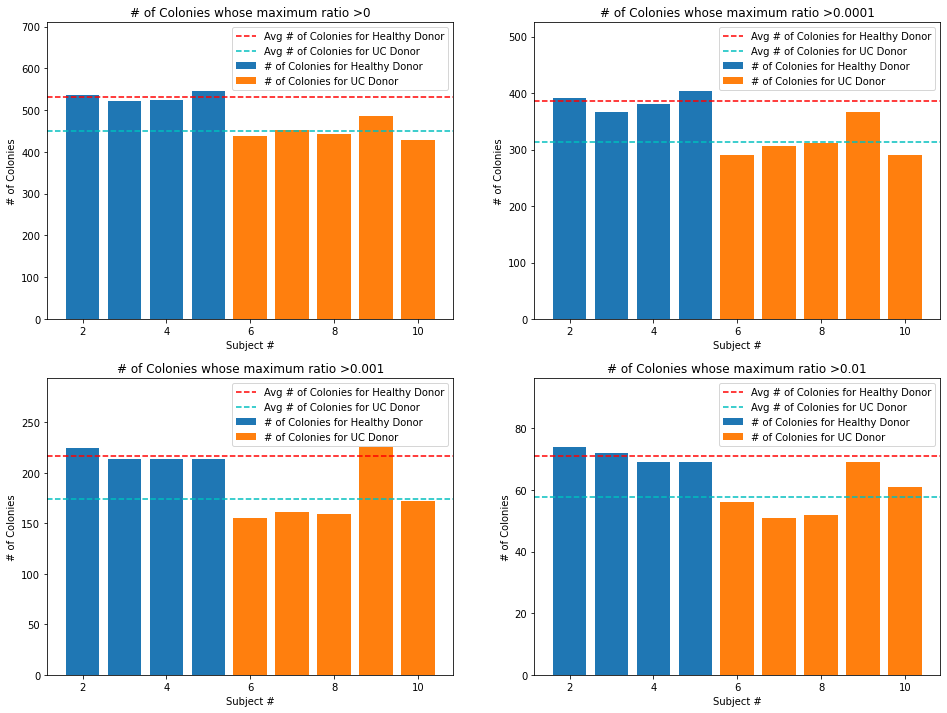

In [182]:
#EDA Finding 1: numbers of colonies for UC donor are significantly less than those for healthy donors.
plot_x = stat_df.iloc[:,0]
fig,axes = plt.subplots(2,2,figsize=(16,12))
for i in range(0,4):
    axes[math.floor(i/2),i%2].set_xlabel("Subject #")
    axes[math.floor(i/2),i%2].set_ylabel("# of Colonies")
    axes[math.floor(i/2),i%2].set_title("# of Colonies whose maximum ratio "+stat_df.columns[i+1])
    axes[math.floor(i/2),i%2].set_ylim([0,stat_df.iloc[:,i+1].max()*1.3])
    axes[math.floor(i/2),i%2].bar(stat_df.iloc[0:4,0],stat_df.iloc[0:4,i+1],label="# of Colonies for Healthy Donor")
    axes[math.floor(i/2),i%2].bar(stat_df.iloc[4:10,0],stat_df.iloc[4:10,i+1],label="# of Colonies for UC Donor")
    axes[math.floor(i/2),i%2].axhline(stat_df.iloc[0:4,i+1].mean(),ls="--",c="r",label="Avg # of Colonies for Healthy Donor")
    axes[math.floor(i/2),i%2].axhline(stat_df.iloc[4:10,i+1].mean(),ls="--",c="c",label="Avg # of Colonies for UC Donor")
    axes[math.floor(i/2),i%2].legend()

In [235]:
distance_df = pd.DataFrame(columns=["subject","time","distance","total population"])
reference = pd.DataFrame(test_df.iloc[0,0:-2]).T
#Calculate mahattan distances between samples (from different times and subjects)
#No standardization
for i in range(2,11):
    distance_df_tmp = pd.DataFrame(columns=["subject","time","distance","total population"])
    tmp_dict = {}
    part_df = metadata[metadata["subject"]==i]
    maxlen = len(subject_df_dict[i])
    tmp_df = pd.DataFrame()
    for j in range(0,maxlen):
        smpid = part_df.iloc[j,0]
        smptime = part_df.iloc[j,2]
        tmp_dict["time"] = smptime
        tmp_dict["subject"] = i
        tmp_dict["distance"] = manhattan_distances(reference,pd.DataFrame(subject_df_dict[i].iloc[j,0:-2]).T)[0][0]
        tmp_dict["total population"] = subject_df_dict[i].iloc[j,-2]
        distance_df_tmp = distance_df_tmp.append(pd.DataFrame(tmp_dict,index=[smpid]))
    distance_df_tmp = distance_df_tmp.sort_values("time")
    distance_df = distance_df.append(distance_df_tmp)
display(distance_df)

,subject,time,distance,total population
2-D0AM,2,0.0,0.000000,8.724134e+06
2-D0PM,2,0.5,0.720306,3.674454e+07
2-D1AM,2,1.0,1.507191,6.111956e+10
2-D1PM,2,1.5,1.511772,6.602661e+10
2-D2AM,2,2.0,1.643511,1.761752e+11
...,...,...,...,...
10-D61,10,61.0,1.210609,2.566034e+10
10-D62,10,62.0,1.134540,6.876649e+10
10-D63,10,63.0,1.177479,3.709152e+10
10-D64AM,10,64.0,1.152032,2.281254e+11


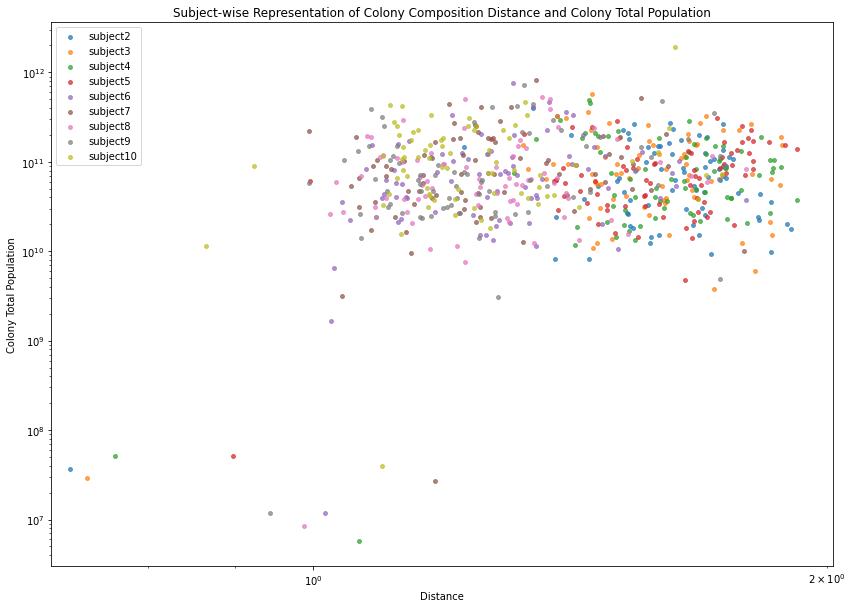

In [273]:
plt.figure(figsize=(14,10))
for i in range(2,11):
    plt.scatter(distance_df[distance_df["subject"]==i]["distance"],distance_df[distance_df["subject"]==i]["total population"],s=15,alpha=0.7,label="subject"+str(i))
plt.xlabel("Distance")
plt.ylabel("Colony Total Population")
plt.title("Subject-wise Representation of Colony Composition Distance and Colony Total Population")
plt.xscale("log")
plt.yscale("log")
plt.legend()

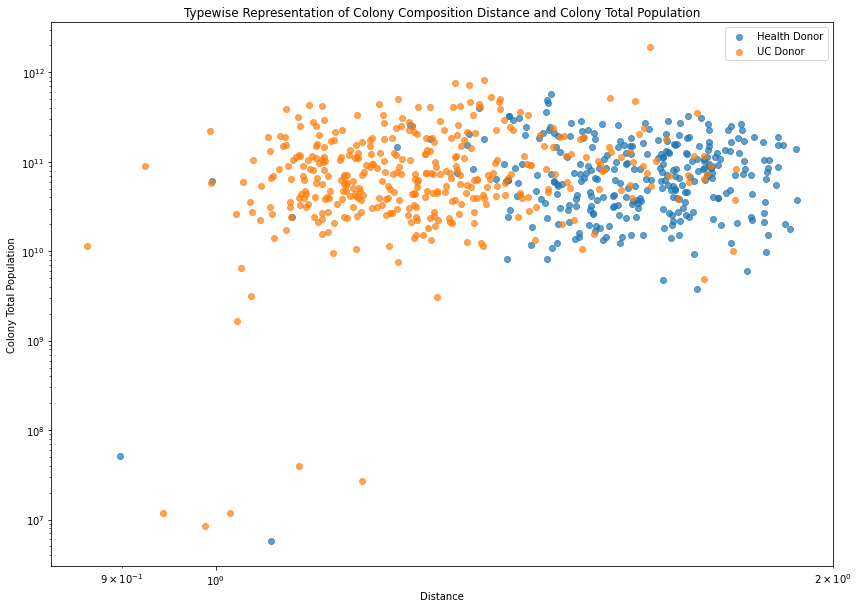

In [274]:
plt.figure(figsize=(14,10))
plt.scatter(distance_df[distance_df["subject"]<6]["distance"],distance_df[distance_df["subject"]<6]["total population"],alpha=0.7,label="Health Donor")
plt.scatter(distance_df[distance_df["subject"]>=6]["distance"],distance_df[distance_df["subject"]>=6]["total population"],alpha=0.7,label="UC Donor")
plt.xlabel("Distance")
plt.ylabel("Colony Total Population")
plt.title("Typewise Representation of Colony Composition Distance and Colony Total Population")
plt.xscale("log")
plt.yscale("log")
plt.legend()

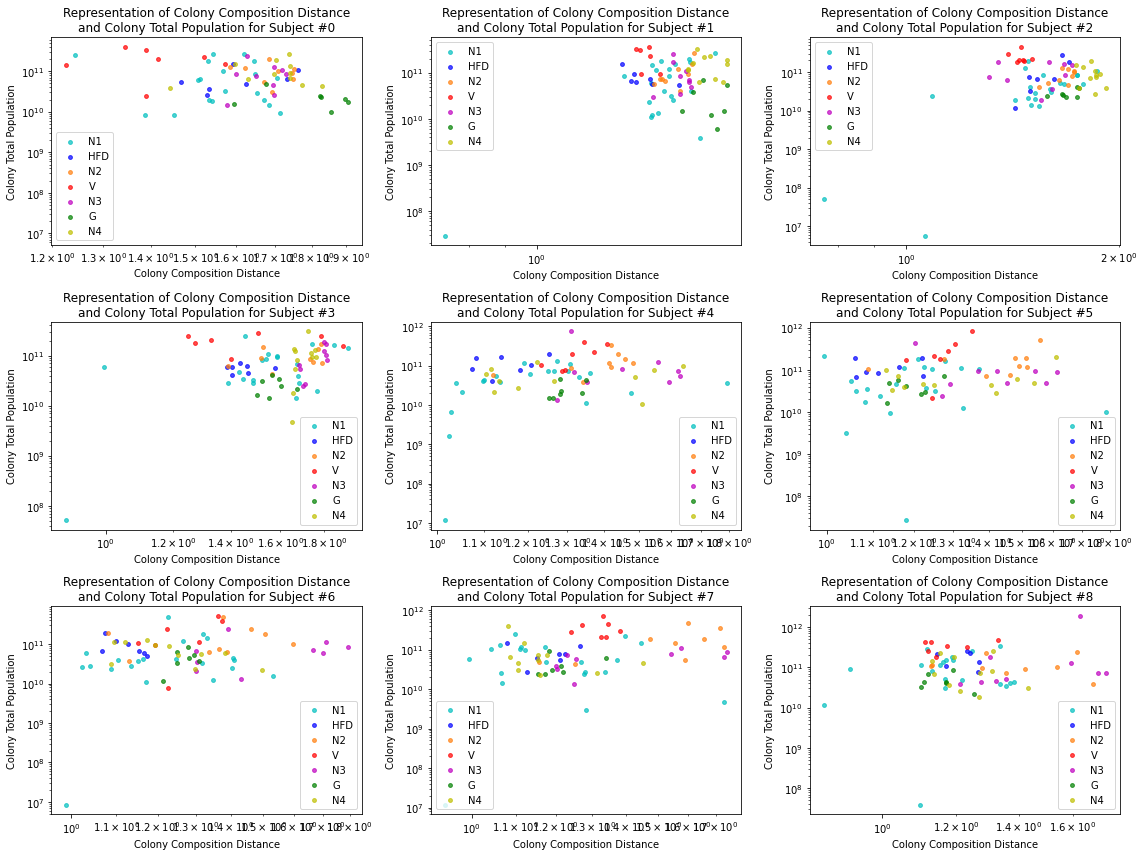

In [304]:
"""Explanation for periods:
N1 - normal period 1 without any perturbation (0-21.5 days)
HFD - High Fad Diet perturbation (21.5-28.5 days)
N2 - normal period 2 without any perturbation (28.5-35.5 days)
V - Vancomycin perturbation (35.5-42.5 days)
N3 - normal period 3 without any perturbation (42.5-50.5 days)
G - Gentamicin perturbation (50.5-57.5 days)
N4 - normal period 4 without any perturbation (57.5-64.5 days)
"""
def draw_subjectwise_period_distributions(distance_df):
    period_list = [0, 21.5, 28.5, 35.5, 42.5, 50.5, 57.5]
    label_list = ["N1", "HFD", "N2", "V", "N3", "G", "N4"]
    color_list = ["c", "b", "#ff7f0e", "r", "m", "g", "y"]
    fig2,axes2 = plt.subplots(3,3,figsize=(16,12))
    for i in range(0,9):
        part_df = distance_df[distance_df["subject"]==i+2]
        part_df[part_df["time"]<period_list[1]]["distance"]
        axes2[math.floor(i/3),i%3].scatter(part_df[part_df["time"]<period_list[1]]["distance"],
                                            part_df[part_df["time"]<period_list[1]]["total population"],c=color_list[0],label=label_list[0],
                                            s=15,alpha=0.7)
        axes2[math.floor(i/3),i%3].scatter(part_df[(part_df["time"]>period_list[1])&(part_df["time"]<period_list[2])]["distance"],
                                            part_df[(part_df["time"]>period_list[1])&(part_df["time"]<period_list[2])]["total population"]
                                            ,c=color_list[1],label=label_list[1],s=15,alpha=0.7)
        axes2[math.floor(i/3),i%3].scatter(part_df[(part_df["time"]>period_list[2])&(part_df["time"]<period_list[3])]["distance"],
                                            part_df[(part_df["time"]>period_list[2])&(part_df["time"]<period_list[3])]["total population"]
                                            ,c=color_list[2],label=label_list[2],s=15,alpha=0.7)
        axes2[math.floor(i/3),i%3].scatter(part_df[(part_df["time"]>period_list[3])&(part_df["time"]<period_list[4])]["distance"],
                                            part_df[(part_df["time"]>period_list[3])&(part_df["time"]<period_list[4])]["total population"]
                                            ,c=color_list[3],label=label_list[3],s=15,alpha=0.7)
        axes2[math.floor(i/3),i%3].scatter(part_df[(part_df["time"]>period_list[4])&(part_df["time"]<period_list[5])]["distance"],
                                            part_df[(part_df["time"]>period_list[4])&(part_df["time"]<period_list[5])]["total population"]
                                            ,c=color_list[4],label=label_list[4],s=15,alpha=0.7)
        axes2[math.floor(i/3),i%3].scatter(part_df[(part_df["time"]>period_list[5])&(part_df["time"]<period_list[6])]["distance"],
                                            part_df[(part_df["time"]>period_list[5])&(part_df["time"]<period_list[6])]["total population"]
                                            ,c=color_list[5],label=label_list[5],s=15,alpha=0.7)
        axes2[math.floor(i/3),i%3].scatter(part_df[part_df["time"]>period_list[6]]["distance"],
                                            part_df[part_df["time"]>period_list[6]]["total population"]
                                            ,c=color_list[6],label=label_list[6],s=15,alpha=0.7)
        axes2[math.floor(i/3),i%3].legend()
        axes2[math.floor(i/3),i%3].set_xscale("log")
        axes2[math.floor(i/3),i%3].set_yscale("log")
        axes2[math.floor(i/3),i%3].set_xlabel("Colony Composition Distance")
        axes2[math.floor(i/3),i%3].set_ylabel("Colony Total Population")
        axes2[math.floor(i/3),i%3].set_title(f"Representation of Colony Composition Distance\nand Colony Total Population for Subject #{i:d}")
    plt.tight_layout()
draw_subjectwise_period_distributions(distance_df)

In [318]:
scaler = StandardScaler()
distance_df_std = pd.DataFrame(columns=["subject","time","distance","total population"])
#Calculate mahattan distances between samples (from different times and subjects)
#No standardization
for i in range(2,11):
    distance_df_std_tmp = pd.DataFrame(columns=["subject","time","distance","total population"])
    standardized_df = subject_df_dict[i].iloc[:,0:-2].copy()
    scaler.fit(standardized_df)
    standardized_df = scaler.transform(standardized_df)
    reference_std = pd.DataFrame(standardized_df[0]).T
    tmp_dict = {}
    part_df = metadata[metadata["subject"]==i]
    maxlen = len(standardized_df)
    tmp_df = pd.DataFrame()
    for j in range(0,maxlen):
        smpid = part_df.iloc[j,0]
        smptime = part_df.iloc[j,2]
        tmp_dict["time"] = smptime
        tmp_dict["subject"] = i
        tmp_dict["distance"] = manhattan_distances(reference_std,pd.DataFrame(standardized_df[j]).T)[0][0]
        tmp_dict["total population"] = subject_df_dict[i].iloc[j,-2]
        distance_df_std_tmp = distance_df_std_tmp.append(pd.DataFrame(tmp_dict,index=[smpid]))
    distance_df_std_tmp = distance_df_std_tmp.sort_values("time")
    distance_df_std = distance_df_std.append(distance_df_std_tmp)
display(distance_df_std)

,subject,time,distance,total population
2-D0AM,2,0.0,0.000000,8.724134e+06
2-D0PM,2,0.5,763.454883,3.674454e+07
2-D1AM,2,1.0,644.841039,6.111956e+10
2-D1PM,2,1.5,701.059400,6.602661e+10
2-D2AM,2,2.0,782.200682,1.761752e+11
...,...,...,...,...
10-D61,10,61.0,184.276732,2.566034e+10
10-D62,10,62.0,257.536873,6.876649e+10
10-D63,10,63.0,230.937497,3.709152e+10
10-D64AM,10,64.0,199.152237,2.281254e+11


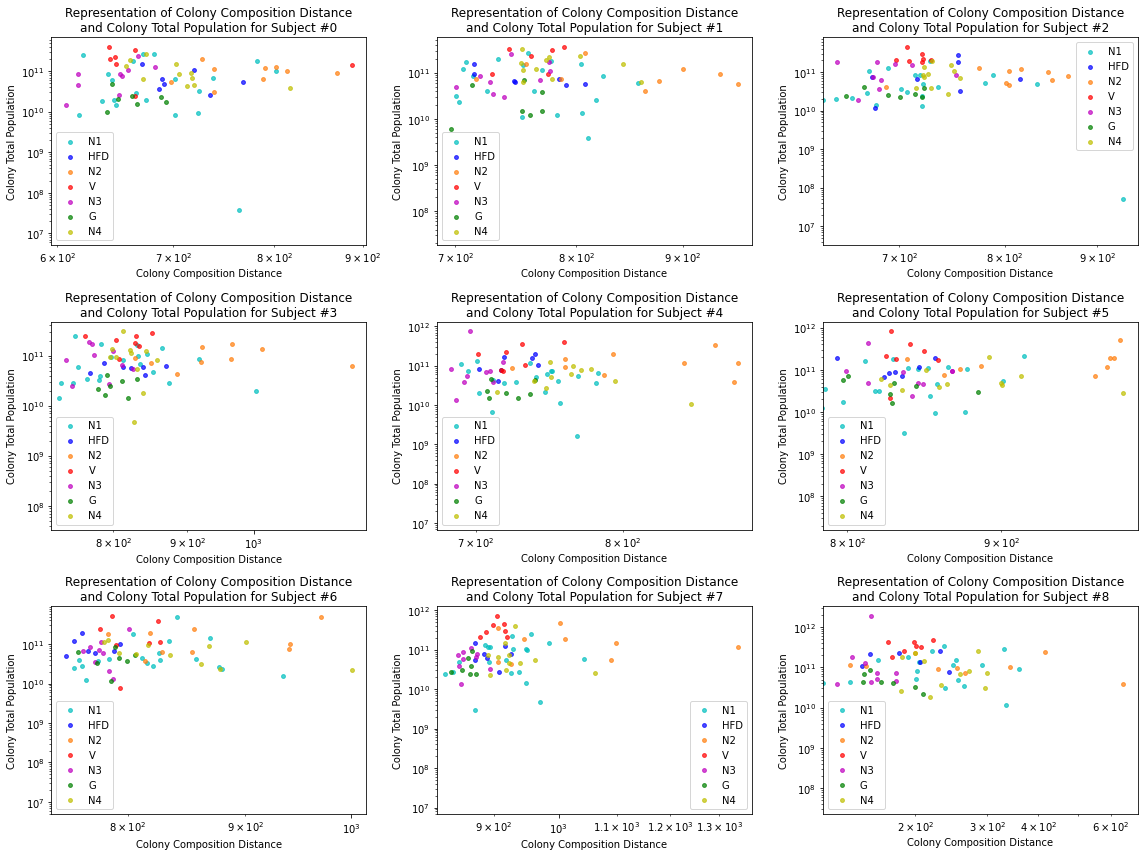

In [319]:
draw_subjectwise_period_distributions(distance_df_std)

In [115]:
dates = {"HFD":[21.5, 28.5], "V":[35.5, 42.5], "G": [50.5, 57.5]}
#HFD: High Fat Diet
#V: Vancomycin
#G: Gentamicin
#list: first element is the start date, second one is the end date

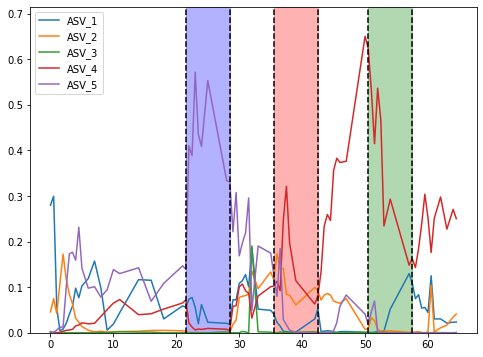

In [136]:
def draw_single_colony(df,index,dates):
    plt.figure(figsize=(8,6))
    maxlim = 0
    for i in index:
        if(maxlim<df["ASV_"+str(i)].max()*1.1):
            maxlim = df["ASV_"+str(i)].max()*1.1
        plt.plot(df["time"],df["ASV_"+str(i)],label="ASV_"+str(i))
    plt.legend()
    plt.ylim([0,maxlim])
    plt.fill_between(dates["HFD"],maxlim,color="b",alpha=0.3)
    plt.fill_between(dates["V"],maxlim,color="r",alpha=0.3)
    plt.fill_between(dates["G"],maxlim,color="g",alpha=0.3)
    plt.axvline(dates["HFD"][0],ls="--",c="k")
    plt.axvline(dates["HFD"][1],ls="--",c="k")
    plt.axvline(dates["V"][0],ls="--",c="k")
    plt.axvline(dates["V"][1],ls="--",c="k")
    plt.axvline(dates["G"][0],ls="--",c="k")
    plt.axvline(dates["G"][1],ls="--",c="k")
#Draw a colony raatio variation plot with blue denotes high fat diet period, red deontes vacomycin period & green denotes gentamicin period
#Simply pass dataframe, colony index (list with int's in it) and dates (as it is now!) in and get a plot
draw_single_colony(test_df,[1,2,3,4,5],dates)

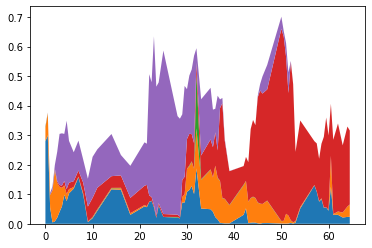

In [137]:
plt.stackplot(test_df["time"], test_df.ASV_1,test_df.ASV_2,test_df.ASV_3,test_df.ASV_4,test_df.ASV_5)

In [194]:
qpcr[qpcr["sampleID"]=="10-D0AM"].mean(axis=1)[0]

39651366.83945533